In [ ]:
#k medio vs p_mob (solo per controllare non ci siano stranezze)

#stessi grafici ma con k medio per ogni p_mob (di base dovrebbe essere 4 ) e coloro p_mob 

#fare due scale free simmetriche con metà dei run (50) !nuovo file SIRS.py
#una con inizializzazione simmetrica e una con solo una delle due (5 e 3+2)

#e rifare tutto

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
from IPython.display import display, clear_output
from scipy import signal
from scipy import fftpack
from numpy.fft import fft, fftfreq
import os
import pandas as pd
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 10})

# import custom module
import SIRS


from itertools import *
from operator import *

%matplotlib inline

# Probability of extinction and extinction time

In [3]:
#this functions filters the timestamps keeping the ones for which I = 0. Then 
#creates groups of subsequent timestamps and checks if a group is longer then the window, i.e. if I = 0 for 
#number of timestamps >= window
 

def EX_extinction(I, ext_win):
    
    extinted = False
    time_extinction = 0
    
    possible_ext_time = np.argwhere(I==0.)
    
    for key, group in groupby(enumerate(possible_ext_time), lambda x: x[0] - x[1]): 
        group = list(map(itemgetter(1), group)) 
        if extinted == True: 
            #it can happen that I set as extinted 
            #a disease that comesback. If it comes back it means that 
            #there is a new group of subsequent number of length != 0. 
            #If This new group is longer than the time window this is the new "extinction". 
            #If not, then disease just had a come bck but is not extinted
            if len(group) >= ext_win:
                extinted = True
                time_extinction = group[0]
            elif len(group) < ext_win:
                extinted = False
                time_extinction = 0
        else:
            if len(group) >= ext_win:
                extinted = True
                time_extinction = group[0]
                
    return extinted, time_extinction

In [9]:
#this functions filters the timestamps keeping the ones for which I = 0. Then 
#creates groups of subsequent timestamps and checks if a group is longer then the window, i.e. if I = 0 for 
#number of timestamps >= window
 

def extinction(I):
    
    time_first_ext = []
    time_ext = []
    
    possible_ext_time = np.argwhere(I==0.)
    
    for key, group in groupby(enumerate(possible_ext_time), lambda x: x[0] - x[1]): 
        group = list(map(itemgetter(1), group)) 
        
        time_first_ext.append(group[0]) #first ext time
        time_ext.append(len(group))    #time of extinction
        
    return time_first_ext, time_ext

In [22]:
#epidemics parameters
beta = 0.075
mu = 0.15
gamma = 0.02

directory_name = "data/"+str(beta)+"_"+str(mu)+"_"+str(gamma)

p_mob_list = np.linspace(0.03,0.2,20)[0:15]

n_runs = 100
n_iter = 1000

#window_list = [40,50,70,85,100, 150,200]

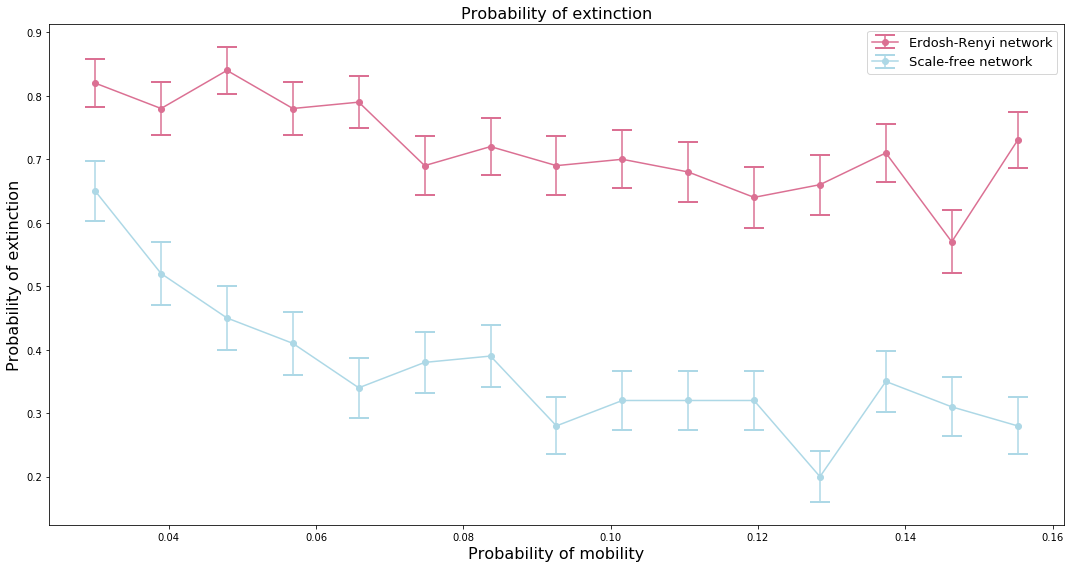

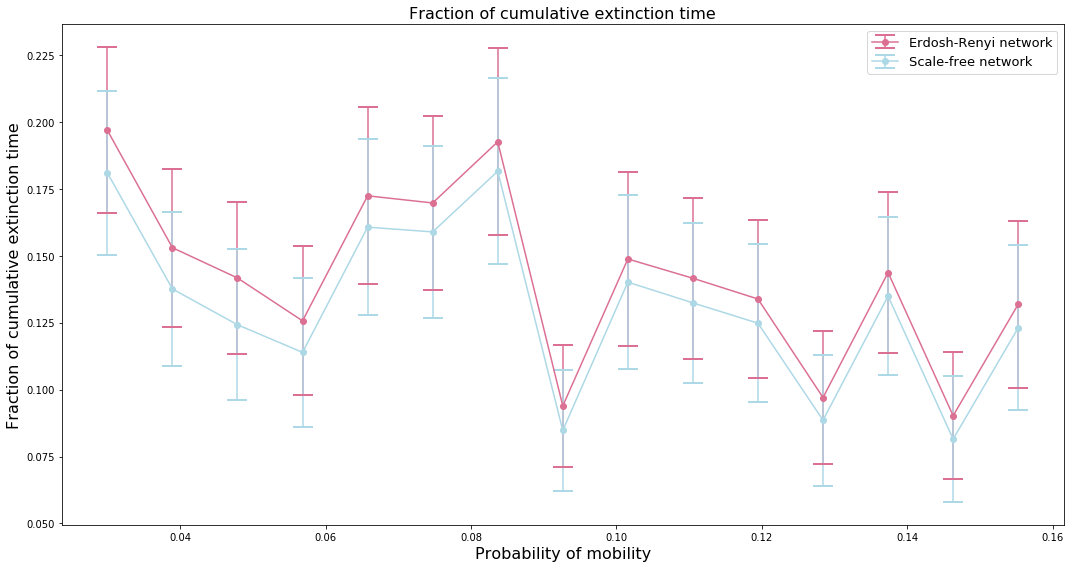

In [24]:
#for window in window_list:

ext_er=[] #will give me probability of extincion
ext_sf=[] #will give me probability of extincion
error_t_ext_er = []
error_t_ext_sf = []
t_ext_sum_er = []
t_ext_sum_sf = []
t_ext_std_er = []
t_ext_std_sf = []

for p_mob in p_mob_list:

    p_mob_dn = "/pmob_"+"{:3f}".format(p_mob)

    #print(directory_name+p_mob_dn)

    prob_ext_er = 0
    prob_ext_sf = 0
    t_ext_list_er = []
    t_ext_list_sf = []
    t_er = []
    t_sf = []

    

    for run in range(n_runs):

        filename_er = directory_name+p_mob_dn+"/SIR_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/SIR_sf_"+str(run)+".txt"

        SIR_er = np.loadtxt(filename_er)
        SIR_sf = np.loadtxt(filename_sf)
        

                
        _ , time_ext_er = extinction(SIR_er[:,1])
        _ , time_ext_sf = extinction(SIR_sf[:,1])
        
            
        e_er = len(time_ext_er) > 1 #asymmetry in initialization
        e_sf = np.any(SIR_sf[:,1] == 0)
        
        prob_ext_er += int(e_er)
        prob_ext_sf += int(e_sf)

        
        #t_ext_list_er.append(time_ext_er)
        #t_ext_list_sf.append(time_ext_sf)
        t_er.append(sum(time_ext_er)/n_iter)
        t_sf.append(sum(time_ext_sf)/n_iter)
        
        t_ext_list_er+=time_ext_er
        t_ext_list_sf+=time_ext_sf
        
    t_er = np.array(t_er)
    t_sf = np.array(t_sf)
    t_ext_sum_er.append(np.mean(t_er))
    t_ext_sum_sf.append(np.mean(t_sf)) 
    t_ext_std_er.append(np.std(t_er)/np.sqrt(n_runs))
    t_ext_std_sf.append(np.std(t_sf)/np.sqrt(n_runs))

    ext_er.append(prob_ext_er/n_runs)
    ext_sf.append(prob_ext_sf/n_runs)
    
    #print(prob_ext_er/n_runs)
    
    '''fig, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].hist(t_ext_list_er)
    ax[0].set_title("ER network - N=%d"%len(t_ext_list_er))
    ax[1].hist(t_ext_list_sf)
    ax[1].set_title("SF network - N=%d"%len(t_ext_list_sf))
    plt.show()'''
        
        
#error computed as binomial process        
ext_er=np.array(ext_er)       
ext_sf=np.array(ext_sf)       
error_t_ext_er  = np.sqrt(ext_er*(1-ext_er))/np.sqrt(n_runs)
error_t_ext_sf  = np.sqrt(ext_sf*(1-ext_sf))/np.sqrt(n_runs)


fig, ax = plt.subplots(1,1, figsize=(15,8))

ax.errorbar(p_mob_list, ext_er, error_t_ext_er, fmt="-o", marker="o", capthick=2, 
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax.errorbar(p_mob_list, ext_sf, error_t_ext_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")

#ax.plot(p_mob_list, ext_er, "-o",color="palevioletred", label="Erdosh-Renyi network")
#ax.plot(p_mob_list, ext_sf,  "-o",color="lightblue", label="Scale-free network")

ax.set_title("Probability of extinction", fontsize=16)
ax.set_xlabel("Probability of mobility", fontsize=16)
ax.set_ylabel("Probability of extinction", fontsize=16)
ax.legend(fontsize=13, loc='upper right')

fig.tight_layout()

title = directory_name+"/p_extinction.png"
fig.savefig(title)


fig, ax = plt.subplots(1,1, figsize=(15,8))

ax.errorbar(p_mob_list, t_ext_sum_er, t_ext_std_er, fmt="-o", marker="o", capthick=2, 
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax.errorbar(p_mob_list, t_ext_sum_sf, t_ext_std_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")
ax.set_title("Fraction of cumulative extinction time", fontsize=16)
ax.set_xlabel("Probability of mobility", fontsize=16)
ax.set_ylabel("Fraction of cumulative extinction time", fontsize=16)
ax.legend(fontsize=13, loc='upper right')

fig.tight_layout()
title = directory_name+"/p_t_extinction.png"
fig.savefig(title)

In [ ]:
#for window in window_list:
window=100
ext_er=[] #will give me probability of extincion
t_ext_er=[]
ext_sf=[] #will give me probability of extincion
t_ext_sf=[]
error_t_ext_er = []
error_t_ext_sf = []

for p_mob in p_mob_list:

    p_mob_dn = "/pmob_"+"{:3f}".format(p_mob)

    #print(directory_name+p_mob_dn)

    prob_ext_er = 0
    prob_ext_sf = 0
    t_ext_list_er = []
    t_ext_list_sf = []


    for run in range(n_runs):

        filename_er = directory_name+p_mob_dn+"/SIR_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/SIR_sf_"+str(run)+".txt"

        SIR_er = np.loadtxt(filename_er)
        SIR_sf = np.loadtxt(filename_sf)
        
        
        e_er = np.any(SIR_er[:,1] == 0)
        e_sf = np.any(SIR_sf[:,1] == 0)
        
        prob_ext_er += int(e_er)
        prob_ext_sf += int(e_sf)


        '''if p_mob == 0.07586207:
            plt.plot(np.linspace(0,len(SIR_er),len(SIR_er)),SIR_er[:,1], label="er")
            plt.plot(np.linspace(0,len(SIR_sf),len(SIR_sf)),SIR_sf[:,1], label="sf")
            plt.legend()
            plt.show()

        e_er, t_er = extinction(SIR_er[:,1], window)
        e_sf, t_sf = extinction(SIR_sf[:,1], window)

        prob_ext_er += int(e_er)
        prob_ext_sf += int(e_sf)

        if e_er == True:
            t_ext_list_er.append(t_er)
        if e_sf == True:
            t_ext_list_sf.append(t_sf)

    t_ext_list_er = np.array(t_ext_list_er)
    t_ext_er.append(np.mean(t_ext_list_er))
    error_t_ext_er.append(np.std(t_ext_list_er))

    t_ext_sf.append(np.mean(t_ext_list_sf))
    error_t_ext_sf.append(np.std(t_ext_list_sf))
    t_ext_list_sf = np.array(t_ext_list_sf)'''

    ext_er.append(prob_ext_er/n_runs)
    ext_sf.append(prob_ext_sf/n_runs)
        
        
    
    

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(p_mob_list, ext_er, "-o",color="palevioletred", label="Erdosh-Renyi network")
ax[0].plot(p_mob_list, ext_sf,  "-o",color="lightblue", label="Scale-free network")
ax[0].set_title("Probability of extinction", fontsize=16)
ax[0].set_xlabel("Probability of mobility", fontsize=16)
ax[0].set_ylabel("Probability of extinction", fontsize=16)
ax[0].legend(fontsize=13, loc='upper right')

ax[1].errorbar(p_mob_list, t_ext_er, error_t_ext_er, fmt="-o", marker="o", capthick=2, 
                                                       color="palevioletred", label="Erdosh-Renyi network")
ax[1].errorbar(p_mob_list, t_ext_sf, error_t_ext_sf, fmt="-o", marker="o", capthick=2, 
                                                       color="lightblue", label="Scale-free network")
#ax[1].plot(p_mob_list, t_ext_er,  "-o", color="palevioletred", label="Erdosh-Renyi network")
#ax[1].plot(p_mob_list, t_ext_sf,  "-o", color="lightblue", label="Scale-free network")
ax[1].set_title("Extinction time", fontsize=16)
ax[1].set_xlabel("Probability of mobility", fontsize=16)
ax[1].set_ylabel("Mean time of extinction", fontsize=16)
ax[1].legend(fontsize=13, loc='upper right')

fig.tight_layout()

title = "Window:"+str(window)
plt.suptitle(title,fontsize=23, y=1.05)

title = directory_name+"/extinction.png"
fig.savefig(title)


# DEBUG: 


CHECKING IF NUMBER OF TRAVELLING NODES IS CHANGED CORRECTLY 

Do this by counting the number of travelling nodes at each iteration and run: number of travelling nodes must be consistent at each run in same p_mob but must be different for each p_mob

In [ ]:
#epidemics parameters
beta = 0.075
mu = 0.15
gamma = 0.016

directory_name = str(beta)+"_"+str(mu)+"_"+str(gamma)

p_mob_list = np.linspace(0.03,0.2,20)[0:18]

n_runs = 30


travelling_er_old = 0
travelling_sf_old = 0

for p_mob in p_mob_list:

    p_mob_dn = "/pmob_"+"{:3f}".format(p_mob)
    
    filename_er = directory_name+p_mob_dn+"/travellers_er_0.txt"
    filename_sf = directory_name+p_mob_dn+"/travellers_sf_0.txt"
        
    travelling_er_new = len(np.loadtxt(filename_er))
    travelling_sf_new = len(np.loadtxt(filename_sf))


    
    #check 0.a
    if travelling_er_new == travelling_er_old: 
        print("Check 0.a failed for p_mob",p_mob)
        break
    #check 0.b
    if travelling_sf_new == travelling_sf_old: 
        print("Check 0.b failed for p_mob", p_mob)
        break
        
    #print("Travelling er:", travelling_er_new)
    #print("Travelling sf:", travelling_sf_new)
    
    for run in range(n_runs):

        filename_er = directory_name+p_mob_dn+"/travellers_er_"+str(run)+".txt"
        filename_sf = directory_name+p_mob_dn+"/travellers_sf_"+str(run)+".txt"
        
        travelling_er = len(np.loadtxt(filename_er))
        travelling_sf = len(np.loadtxt(filename_sf))
        
        #check1
        if travelling_er != travelling_sf : 
            print("Check_1 failed for run {} and p_mob {}".format(run, p_mob))
            break
        #check_2.a
        if travelling_er != travelling_er_new : 
            print("Check 2.a failed for run {} and p_mob {}".format(run, p_mob))
            break
        #check_2.b
        if travelling_sf != travelling_sf_new : 
            print("Check 2.b failed for run {} and p_mob {}".format(run, p_mob))
            break
      
    travelling_er_old = travelling_er_new
    travelling_sf_old = travelling_er_new
            

In [5]:
0*10

0

In [6]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]